In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 5 2024

@author: Yaning
"""
# functions for simulating agent data
# this file address is your own
%run Documents/pyro_models/multi_agent_simulation.py
%run Documents/pyro_models/normal_log_model.py

import os
import numpy as np
# from turtle import position
import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean 
import csv

In [2]:
# prior mean (mean_u) is between 0 and 10
# prior variance (var_u) is between 1. to 10.
# estimation/likelihood variance is between 1. to 10.

mean_u_list = np.linspace(0., 10., 5)
sigma_u_list = np.linspace(3., 13., 5)
sigma_es_list = np.linspace(1., 10., 5)


# initialise trial combinations
repetition = 10
real_delays = [1., 3., 7., 13., 24., 32., 45., 58., 75., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [5.]
# LL values by percentage of SS
LL_values_p = [1.05, 1.055, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, \
               1.85, 1.9, 2.05, 2.25, 2.55, 2.85, 3.05, 3.45, 3.85]

# initialise the environment
environment = Environment(SS_values, LL_values_p, delays, repetition)

In [7]:
# setup the optimizer
# the learning rate was 0.0005
def inference(actions, delays, ss_values, ll_values, real_params):

    # this is for running the notebook in our testing framework
    smoke_test = ('CI' in os.environ)
    # the step was 2000
    n_steps = 2 if smoke_test else 10

    # assert pyro.__version__.startswith('1.8.6')

    # clear the param store in case we're in a REPL
    pyro.clear_param_store()

    # adam_params = {"lr": 0.05, "npart": 15, "betas": (0.90, 0.999)}
    adam_params = {"lr": 0.1}
    optimizer = Adam(adam_params)
    # setup the inference algorithm
    svi = SVI(model_normal_log, guide_normal_log, optimizer, loss=Trace_ELBO())

    loss = []
    pbar = tqdm(range(n_steps), position = 0)
    # do gradient steps
    for step in pbar:
        loss.append(torch.tensor(svi.step(actions, delays, ss_values, ll_values)))
        pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
        if torch.isnan(loss[-1]):
            break
    plt.figure()
    plt.plot(loss)
    plt.xlabel("iter step")
    plt.ylabel("ELBO loss")
    plt.title("ELBO minimization during inference")
    plt.savefig('Documents/pyro_models/plots/parameter' + real_params +'.png')
    plt.show()

    # grab the posterior parameters with own guide
    mean_u_mean_q = pyro.param("mean_u_mean_q").item()
    mean_u_sigma_q = pyro.param("mean_u_sigma_q").item()
    sigma_u_mean_q = pyro.param("sigma_u_mean_q").item()
    sigma_u_sigma_q = pyro.param("sigma_u_sigma_q").item()
    sigma_es_mean_q = pyro.param("sigma_es_mean_q").item()
    sigma_es_sigma_q = pyro.param("sigma_es_sigma_q").item()

    # # grab posterior from auto guide
    # dict = {}
    # for name, value in pyro.get_param_store().items():
    #     dict[name] = pyro.param(name)

    return [mean_u_mean_q, mean_u_sigma_q, sigma_u_mean_q, \
            sigma_u_sigma_q, sigma_es_mean_q, sigma_es_sigma_q]

Mean ELBO 2217.78: 100%|████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]


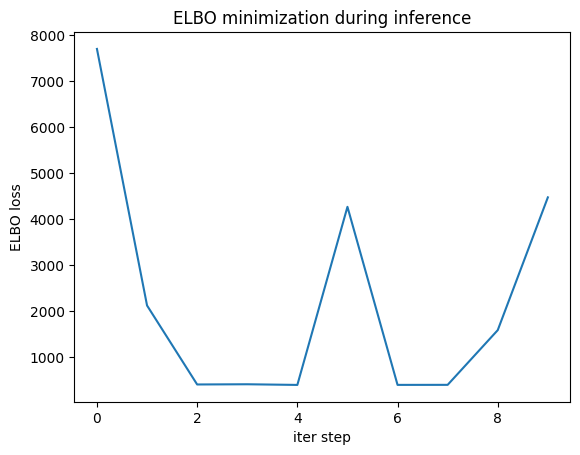

{'mean_u': {10.0: [0.646776020526886]}, 'sigma_u': {13.0: [2.6452765464782715]}, 'sigma_es': {1.0: [0.35472333431243896]}}
['mean_u', 'sigma_u', 'sigma_es']
['{10.0: [0.646776020526886]}', '{13.0: [2.6452765464782715]}', '{1.0: [0.35472333431243896]}']


In [11]:
sample_repeat = 1
post_dict = {'mean_u':{}, 'sigma_u':{}, 'sigma_es':{}}

def add_posterior(key, dic, value):
    if key in dic:
        dic[key].append(value)
    else:
        dic[key]= []
        dic[key].append(value)

for i in range(sample_repeat):
    mean_u = np.random.choice(mean_u_list)
    sigma_u = np.random.choice(sigma_u_list)
    sigma_es = np.random.choice(sigma_es_list)
    real_params = str(mean_u) + '_' + str(sigma_u) + '_' + str(sigma_es) 
    # simulation
    actions, delays, ss_values, ll_values = decision(mean_u, sigma_u, sigma_es, environment)
    actions = torch.tensor(actions)
    delays = torch.tensor(delays)
    ss_values = torch.tensor(ss_values)
    ll_values = torch.tensor(ll_values)

    mean_u_mean_q, mean_u_sigma_q, sigma_u_mean_q, \
        sigma_u_sigma_q, sigma_es_mean_q, sigma_es_sigma_q =\
              inference(actions, delays, ss_values, ll_values, real_params)
    
    add_posterior(mean_u, post_dict['mean_u'], mean_u_mean_q)
    add_posterior(sigma_u, post_dict['sigma_u'], sigma_u_mean_q)
    add_posterior(sigma_es, post_dict['sigma_es'], sigma_es_mean_q)

print(post_dict)
# get the raw results, record them in csv file in the folder
file = open('test_csv.csv', 'w', newline='')
fields = ['mean_u', 'sigma_u', 'sigma_es']
writer = csv.DictWriter(file, fields)
writer.writeheader()
writer.writerows([post_dict])
file.close()

file =  open('test_csv.csv')
reader = csv.reader(file)
for row in reader:
    print(row)

    
    

In [9]:
type(post_dict)

dict

In [ ]:
post_dict

: 

In [96]:
# sort every paramter in from small to big order
post_post_dict = {'mean_u':{}, 'sigma_u':{}, 'sigma_es':{}}
for i in post_dict.keys():
    sorted_list = sorted(post_dict[i].items())
    for key, value in sorted_list:
        if i == 'mean_u':
            post_post_dict[i][key] = mean(value)
        else: 
            post_post_dict[i][key] = np.exp(mean(value))

lists = sorted(post_post_dict['mean_u'].items())
real_mean_u, posterior_mean_u = zip(*lists)
lists = sorted(post_post_dict['sigma_u'].items())
real_sigma_u, posterior_sigma_u = zip(*lists) 
lists = sorted(post_post_dict['sigma_es'].items())
real_sigma_es, posterior_sigma_es = zip(*lists) 


In [82]:
posterior_sigma_u

(5.6129088998694465, 56.92258899141435)

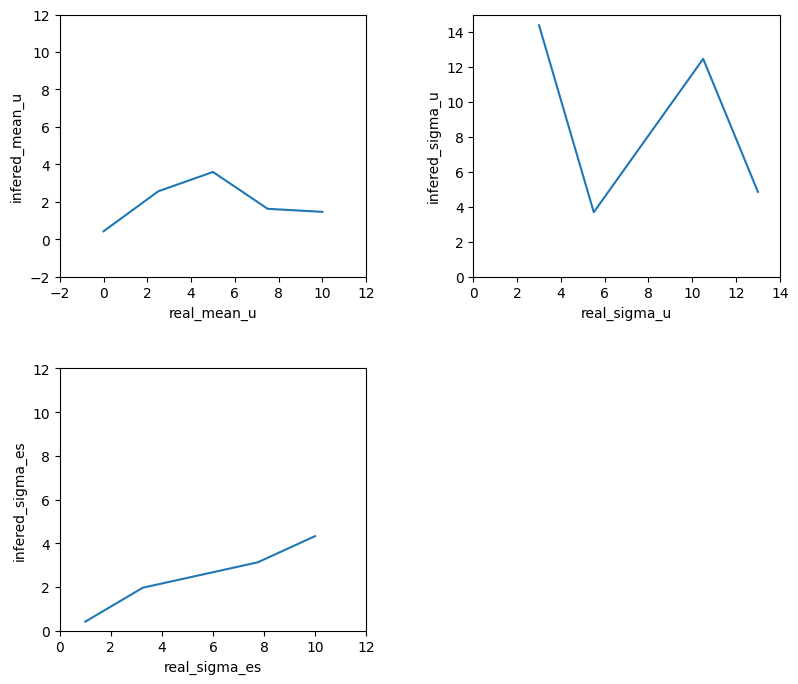

In [103]:
# plot the posterior with simulated data
fig = plt.figure(constrained_layout=False, figsize=(8,8))
gs = fig.add_gridspec(nrows=2, ncols=2, left=0.05, right=0.95, wspace=0.35, hspace=0.35)

ax1 = fig.add_subplot(gs[0,0], xlim = [-2,12], ylim = [-2,12], xlabel = 'real_mean_u', ylabel = 'infered_mean_u')
ax2 = fig.add_subplot(gs[0,1], xlim = [0,14], ylim = [0,15], xlabel = 'real_sigma_u', ylabel = 'infered_sigma_u')
ax3 = fig.add_subplot(gs[1,0], xlim = [0,12], ylim = [0,12], xlabel = 'real_sigma_es', ylabel = 'infered_sigma_es')

ax1.plot(real_mean_u, posterior_mean_u)
ax2.plot(real_sigma_u, posterior_sigma_u)
ax3.plot(real_sigma_es, posterior_sigma_es)

plt.show()

In [98]:
posterior_sigma_u

(14.385412963459453, 3.6915493481734387, 12.467229539714904, 4.855658680044335)